In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay

sns.set(style="whitegrid")

# Cargar los datos
df = pd.read_excel("SAML-D_muestra_1pct.xlsx")
df.columns = df.columns.str.lower().str.replace(" ", "_")
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str), errors='coerce')
df = df.loc[:, ~df.columns.duplicated()]
print("✅ Datos cargados. Dimensiones:", df.shape)


✅ Datos cargados. Dimensiones: (95049, 13)


Valores nulos:
time                      0
date                      0
sender_account            0
receiver_account          0
amount                    0
payment_currency          0
received_currency         0
sender_bank_location      0
receiver_bank_location    0
payment_type              0
is_laundering             0
laundering_type           0
datetime                  0
dtype: int64

Proporción de transacciones sospechosas:
is_laundering
0    99.895843
1     0.104157
Name: proportion, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


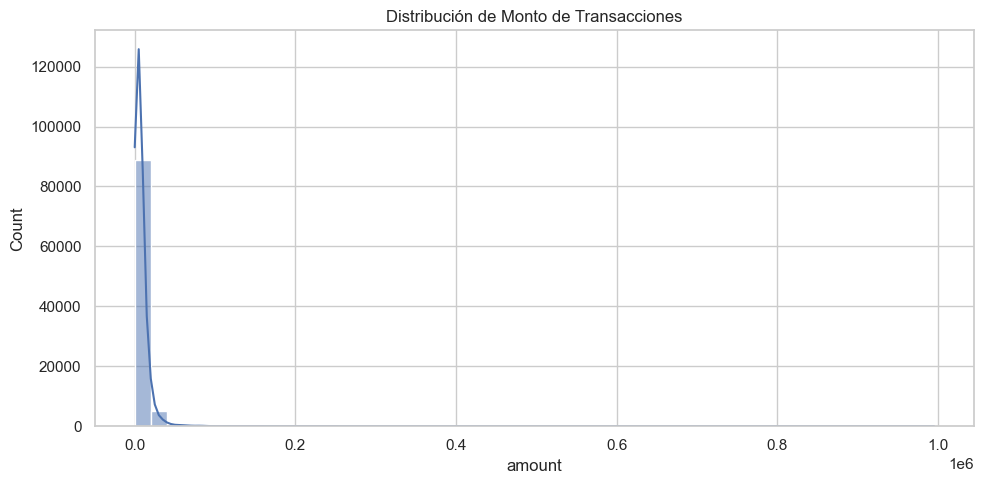

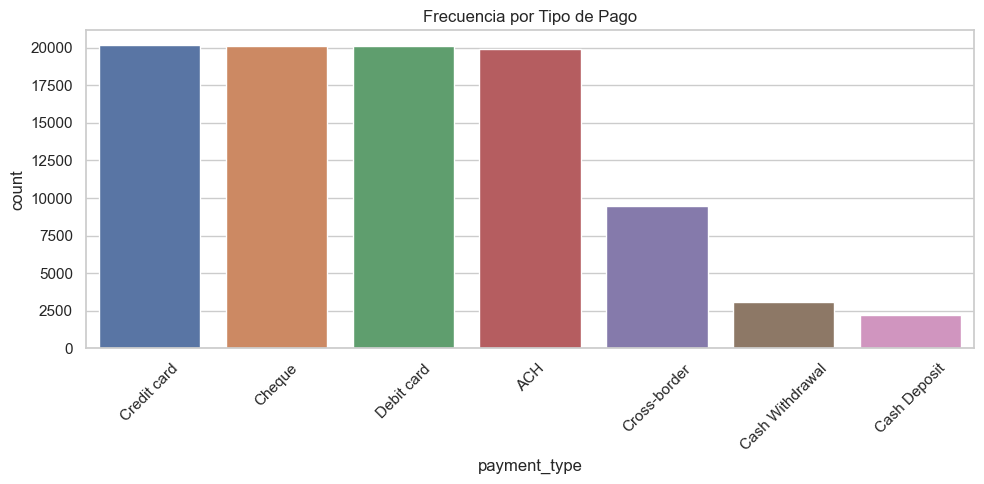

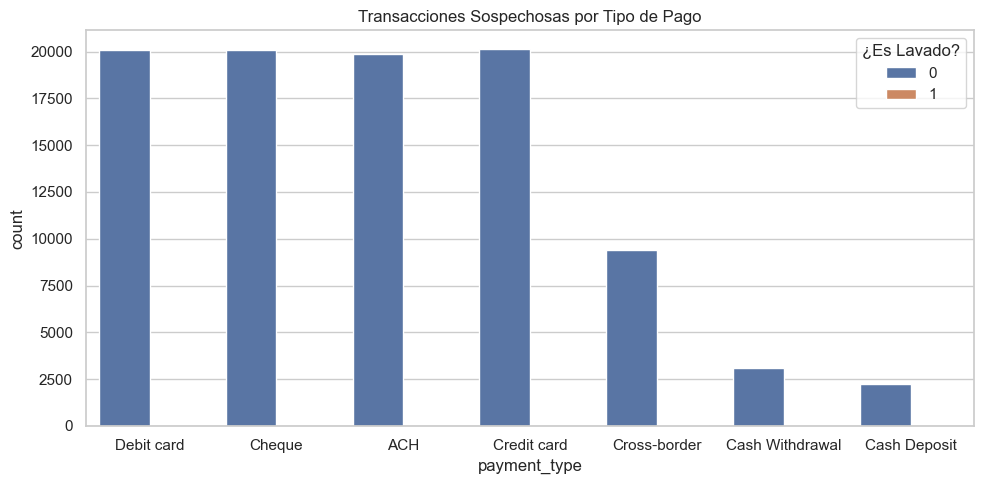

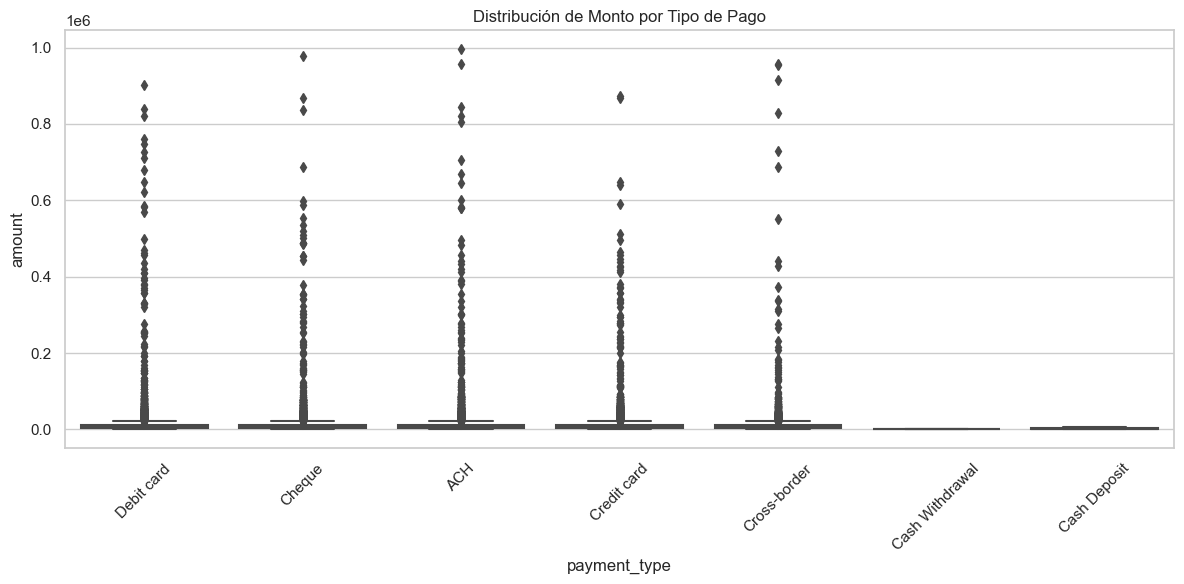

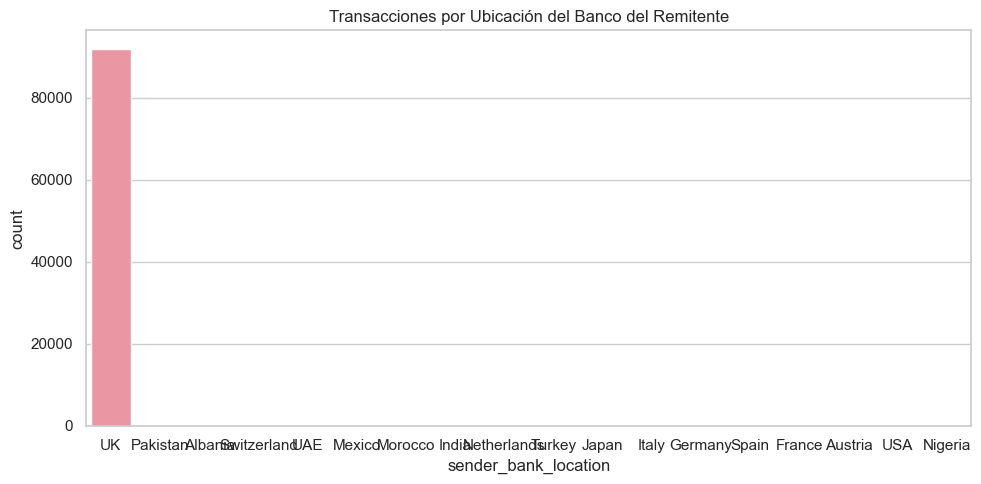

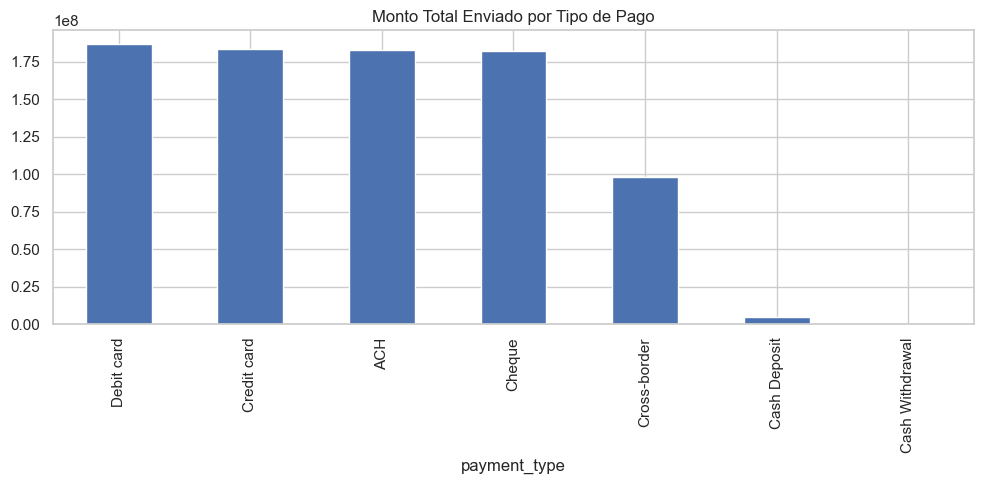

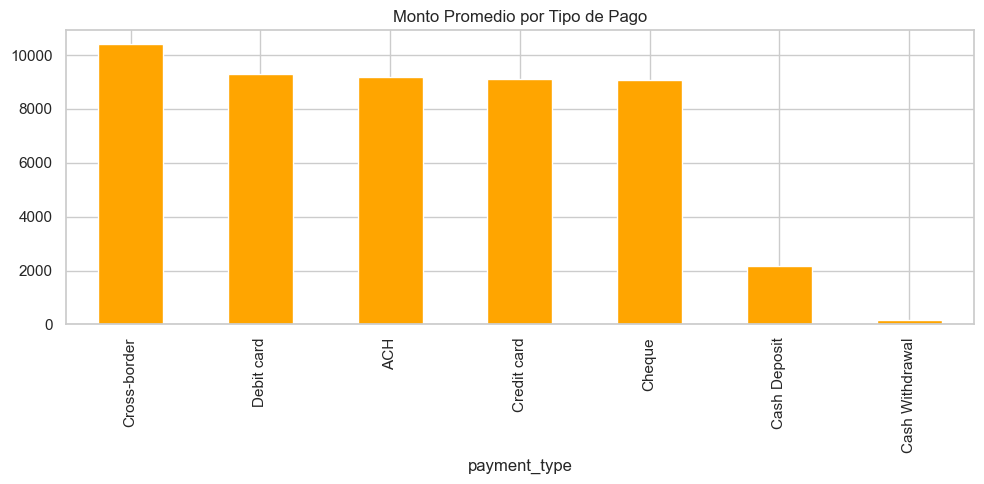

In [3]:
print("Valores nulos:")
print(df.isnull().sum())

print("\nProporción de transacciones sospechosas:")
print(df['is_laundering'].value_counts(normalize=True) * 100)

# Histograma de montos
plt.figure(figsize=(10, 5))
sns.histplot(df['amount'], bins=50, kde=True)
plt.title('Distribución de Monto de Transacciones')
plt.tight_layout()
plt.show()

# Conteo por tipo de pago
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='payment_type', order=df['payment_type'].value_counts().index)
plt.title('Frecuencia por Tipo de Pago')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Transacciones sospechosas por tipo de pago
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='payment_type', hue=df['is_laundering'].astype(str))
plt.title('Transacciones Sospechosas por Tipo de Pago')
plt.legend(title='¿Es Lavado?')
plt.tight_layout()
plt.show()

# Boxplot de montos por tipo de pago
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='payment_type', y='amount')
plt.title('Distribución de Monto por Tipo de Pago')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Conteo por ubicación de banco remitente
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='sender_bank_location')
plt.title('Transacciones por Ubicación del Banco del Remitente')
plt.tight_layout()
plt.show()

# Monto total por tipo de pago
plt.figure(figsize=(10, 5))
df.groupby('payment_type')['amount'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Monto Total Enviado por Tipo de Pago')
plt.tight_layout()
plt.show()

# Monto promedio por tipo de pago
plt.figure(figsize=(10, 5))
df.groupby('payment_type')['amount'].mean().sort_values(ascending=False).plot(kind='bar', color='orange')
plt.title('Monto Promedio por Tipo de Pago')
plt.tight_layout()
plt.show()


In [4]:
df_model = df.copy()
cat_columns = ['payment_type', 'sender_bank_location', 'receiver_bank_location', 'laundering_type']
label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

X = df_model[['amount', 'payment_type', 'sender_bank_location', 'receiver_bank_location']]
y = df_model['is_laundering']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [9]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
roc_auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

# Regresión Logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
roc_auc_log = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


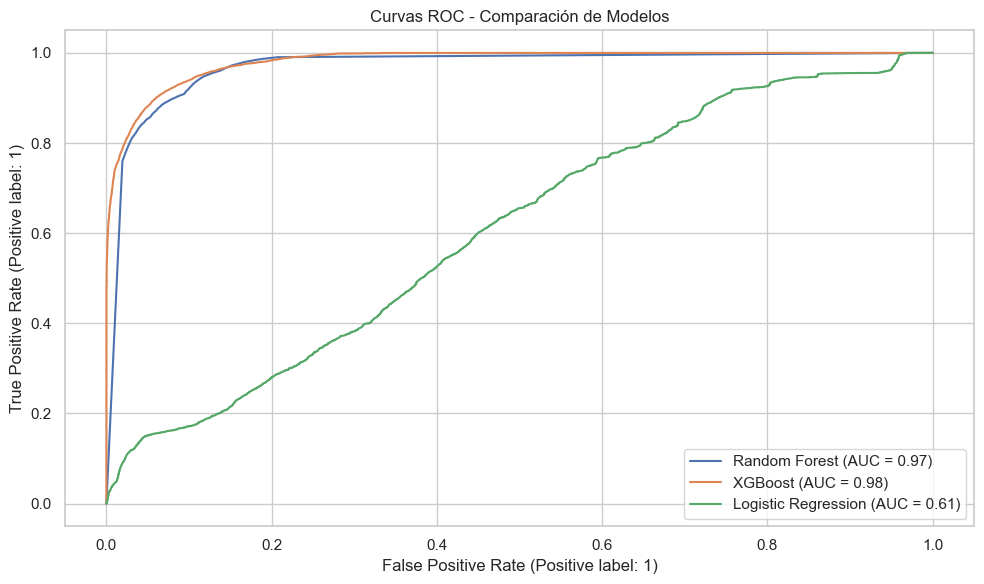

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Crear figura para las curvas ROC
plt.figure(figsize=(10, 6))

# ROC para Random Forest
RocCurveDisplay.from_estimator(rf, X_test, y_test, name="Random Forest", ax=plt.gca())

# ROC para XGBoost
RocCurveDisplay.from_estimator(xgb, X_test, y_test, name="XGBoost", ax=plt.gca())

# ROC para Regresión Logística
RocCurveDisplay.from_estimator(logreg, X_test, y_test, name="Logistic Regression", ax=plt.gca())

# Título y leyenda
plt.title("Curvas ROC - Comparación de Modelos")
plt.grid(True)
plt.tight_layout()
plt.show()



📌 Random Forest
----------------------------------------
              precision    recall  f1-score   support

           0     0.9083    0.9060    0.9071     28464
           1     0.9063    0.9087    0.9075     28506

    accuracy                         0.9073     56970
   macro avg     0.9073    0.9073    0.9073     56970
weighted avg     0.9073    0.9073    0.9073     56970



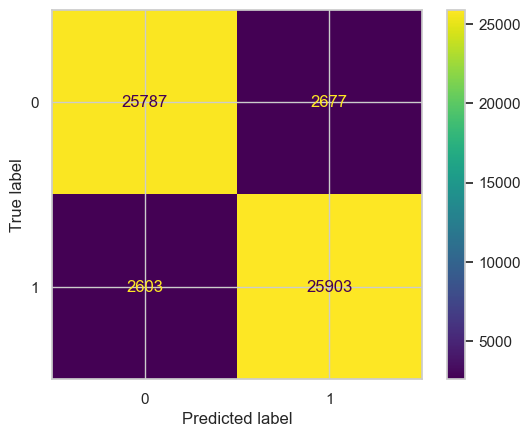

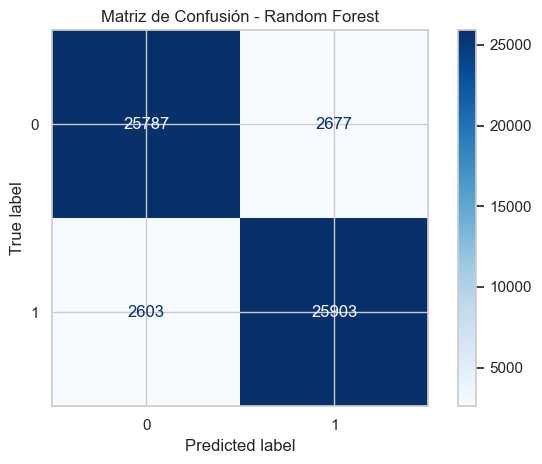


📌 XGBoost
----------------------------------------
              precision    recall  f1-score   support

           0     0.9224    0.9197    0.9210     28464
           1     0.9200    0.9227    0.9214     28506

    accuracy                         0.9212     56970
   macro avg     0.9212    0.9212    0.9212     56970
weighted avg     0.9212    0.9212    0.9212     56970



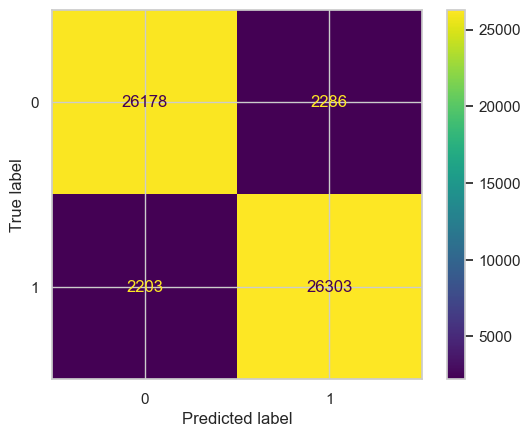

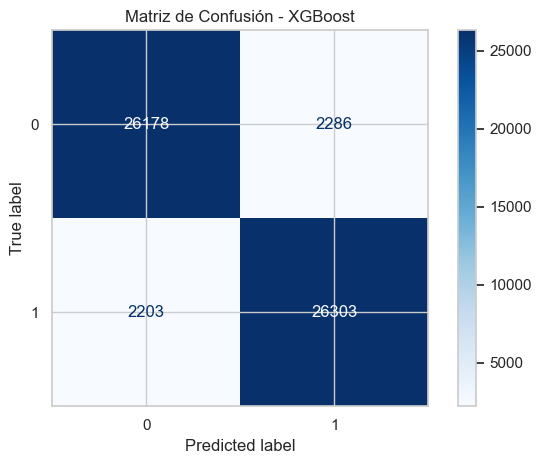


📌 Regresión Logística
----------------------------------------
              precision    recall  f1-score   support

           0     0.5209    0.9025    0.6606     28464
           1     0.6375    0.1712    0.2699     28506

    accuracy                         0.5366     56970
   macro avg     0.5792    0.5369    0.4652     56970
weighted avg     0.5792    0.5366    0.4651     56970



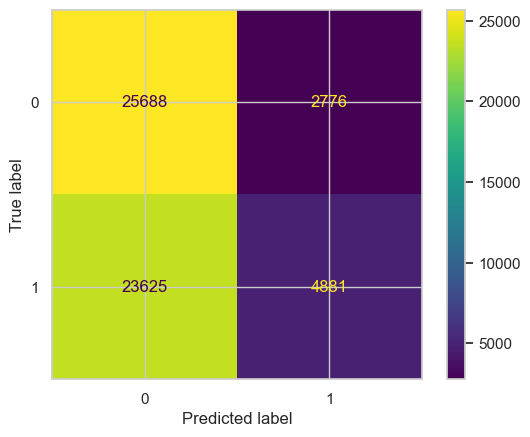

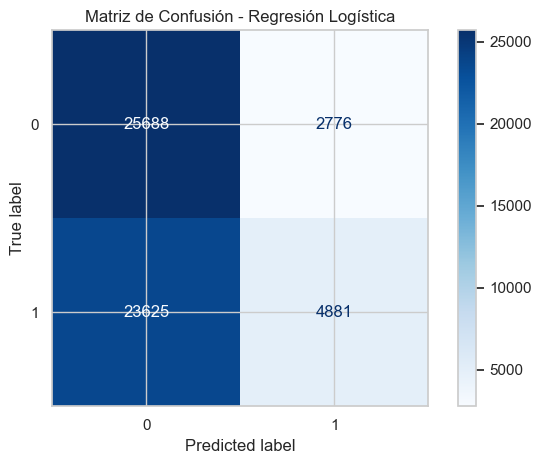

In [15]:
# Generar predicciones
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_log = logreg.predict(X_test)

# Evaluación por modelo
def evaluar_modelo(nombre, y_true, y_pred):
    print(f"\n📌 {nombre}")
    print("-" * 40)
    print(classification_report(y_true, y_pred, digits=4))
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.tight_layout()
    plt.show()

# Ejecutar evaluación para cada modelo
evaluar_modelo("Random Forest", y_test, y_pred_rf)
evaluar_modelo("XGBoost", y_test, y_pred_xgb)
evaluar_modelo("Regresión Logística", y_test, y_pred_log)

🏦 Top 10 cuentas con mayor grado entrante:
Cuenta: 4924631375 - Entradas: 9
Cuenta: 1732955611 - Entradas: 8
Cuenta: 6123762963 - Entradas: 8
Cuenta: 1550796319 - Entradas: 8
Cuenta: 351184098 - Entradas: 8
Cuenta: 2938210715 - Entradas: 8
Cuenta: 3758118046 - Entradas: 8
Cuenta: 357128976 - Entradas: 8
Cuenta: 1881336524 - Entradas: 8
Cuenta: 6084833059 - Entradas: 8

💸 Top 10 cuentas con mayor grado saliente:
Cuenta: 7671695099 - Salidas: 15
Cuenta: 4109275762 - Salidas: 14
Cuenta: 8744145503 - Salidas: 14
Cuenta: 5199663984 - Salidas: 13
Cuenta: 7847480100 - Salidas: 13
Cuenta: 9925811820 - Salidas: 13
Cuenta: 8535463330 - Salidas: 12
Cuenta: 9137244140 - Salidas: 12
Cuenta: 9450915137 - Salidas: 12
Cuenta: 7461673704 - Salidas: 12


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


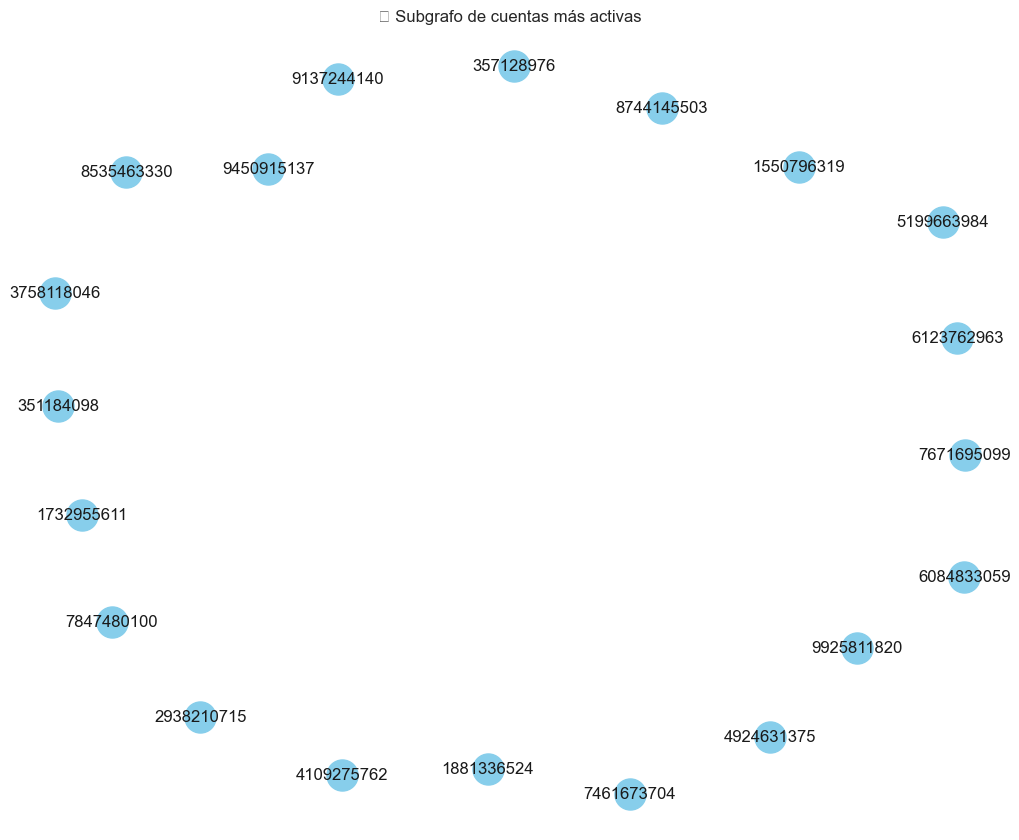

In [12]:
G = nx.from_pandas_edgelist(df, source='sender_account', target='receiver_account', edge_attr='amount', create_using=nx.DiGraph())

in_deg = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:10]
out_deg = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:10]

print("🏦 Top 10 cuentas con mayor grado entrante:")
for node, deg in in_deg:
    print(f"Cuenta: {node} - Entradas: {deg}")

print("\n💸 Top 10 cuentas con mayor grado saliente:")
for node, deg in out_deg:
    print(f"Cuenta: {node} - Salidas: {deg}")

top_nodes = [node for node, _ in in_deg + out_deg]
subG = G.subgraph(top_nodes)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subG, seed=42)
nx.draw(subG, pos, with_labels=True, node_size=500, node_color="skyblue", arrows=True)
plt.title("🔍 Subgrafo de cuentas más activas")
plt.show()
